In [ ]:
%pip install tensorflow pandas numpy scikit-learn matplotlib seaborn jupyter
%pip install plotly ipywidgets  # for interactive plots

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [3]:
pd.set_option('display.max_columns', None)
df = pd.read_csv(r"C:\Users\rahul\Downloads\preprocessed_data.csv")

In [4]:
columns_to_standardize = ['Ad_Slot_Width','Ad_Slot_Height', 'Ad_Slot_Floor_Price']
scaler = StandardScaler()
df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

In [ ]:
df = df.drop(columns=['month', 'year'])

KeyError: "['month', 'year'] not found in axis"

In [7]:
pd.set_option('display.max_columns', None)
df.head(5)

,Region_ID,City_ID,Ad_Exchange,Ad_Slot_Width,Ad_Slot_Height,Ad_Slot_Floor_Price,Creative_ID,Bidding_Price,Paying_Price,Advertiser_ID,User_Tags,browser,browser_version,os,os_version,device,is_mobile,is_tablet,is_pc,is_bot,day,hour,minute,second,weekday,is_weekend,Ad_Slot_Visibility_FifthView,Ad_Slot_Visibility_FirstView,Ad_Slot_Visibility_FourthView,Ad_Slot_Visibility_Na,Ad_Slot_Visibility_OtherView,Ad_Slot_Visibility_SecondView,Ad_Slot_Visibility_ThirdView,Ad_Slot_ID_encoded,Clicked
0,393,393,1.0,1.426482,-0.567776,-0.635100,-0.063968,0.861544,-0.538666,2821,[],10,4,7,65,459,0,0,1,0,0.101297,0.568427,1.142868,-0.524046,2,0,0,0,0,1,0,0,0,1392,0
1,94,95,3.0,1.590702,-0.567776,0.937622,0.990224,0.861544,2.505683,2261,"[10006, 10110, 13776]",4,50,7,76,459,0,0,1,0,1.666838,-0.617917,0.556313,0.532532,5,1,0,0,0,1,0,0,0,1232,0
2,1,1,3.0,-1.299564,0.597392,-0.185751,0.977562,0.861544,-0.952591,2261,[],10,146,7,76,459,0,0,1,0,2.188685,-2.482170,0.321692,4.336215,6,1,0,0,0,1,0,0,0,1316,0
3,3,5,2.0,0.697347,-0.567776,0.757882,-0.063418,-1.160707,1.597720,2821,[],10,146,7,76,459,0,0,1,0,0.101297,-0.617917,-1.086038,-0.524046,2,0,0,1,0,0,0,0,0,731,1
4,80,80,3.0,-0.708374,0.675070,0.937622,-0.061766,0.861544,0.983509,2821,"[10057, 10079, 10006, 10149, 13403, 10063, 10116]",18,143,7,76,459,0,0,1,0,-0.420550,0.737904,0.263036,-0.101415,1,0,0,0,0,1,0,0,0,1231,0


**What Is This Code Doing?**
> This code defines a custom DNN model class named CTRDeepNN, which is designed to predict the probability that an ad will be clicked (Click-Through Rate or CTR).

It works with:
Categorical features (like device type, ad slot, browser type)
Numerical features (like bid price, time of day)
And finally outputs a probability between 0 and 1 using a sigmoid function.

In [33]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

class CTRDeepNN:
  def __init__(self, catagorical_feature_info, numerical_feature_count, target_column='Clicked'):
    self.catagorical_feature_info = catagorical_feature_info
    self.numerical_feature_count = numerical_feature_count
    self.model = None

  def build_model(self, embedding_dim=50, hidden_layers=[512, 256, 128],
                  dropout_rate=0.3, l2_reg=1e-5):

      # Input layers
      inputs = []
      embeddings = []

      # Categorical inputs and embeddings
      for feature_name, vocab_size in self.catagorical_feature_info.items():
          input_layer = Input(shape=(1,), name=f'{feature_name}_input')
          embedding_layer = Embedding(
              input_dim=vocab_size + 1,  # +1 for unknown values
              output_dim=embedding_dim,
              name=f'{feature_name}_embedding'
          )(input_layer)
          embedding_layer = Flatten()(embedding_layer)

          inputs.append(input_layer)
          embeddings.append(embedding_layer)

      # Numerical input
      numerical_input = Input(shape=(len(self.numerical_feature_count),), name='numerical_input')
      inputs.append(numerical_input)


      # Concatenate all features
      if embeddings:
          if self.numerical_feature_count:
              concatenated = Concatenate()(embeddings + [numerical_input])
          else:
              concatenated = Concatenate()(embeddings)
      elif self.numerical_feature_count:
          concatenated = numerical_input
      else:
          # Handle the case where there are no input features
          raise ValueError("No input features provided.")


      # Hidden layers
      x = concatenated
      for i, units in enumerate(hidden_layers):
          x = Dense(
              units,
              activation='relu',
              kernel_regularizer=l2(l2_reg),
              name=f'hidden_{i+1}'
          )(x)
          x = Dropout(dropout_rate)(x)

      # Output layer
      output = Dense(1, activation='sigmoid', name='output')(x)

      # Create model
      self.model = Model(inputs=inputs, outputs=output)

      return self.model

  def compile_model(self, learning_rate=0.001):
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
      self.model.compile(
          optimizer=optimizer,
          loss='binary_crossentropy',
          metrics=['accuracy', 'AUC']
      )

  def get_model_summary(self):
      return self.model.summary()

In [34]:
# Import necessary callbacks for model training
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

# Define the ModelTrainer class to handle the training process
class ModelTrainer:
    # Initialize the class with the model object
    def __init__(self, model):
        self.model = model
        self.history = None

    # Method to prepare data for model training
    def prepare_data(self, df, categorical_cols, numerical_cols):
        # Prepare inputs for the model in a dictionary format
        inputs = {}

        # Categorical inputs (assuming encoded columns exist)
        for col in categorical_cols:
            inputs[f'{col}_input'] = df[f'{col}_encoded'].values

        # Numerical input
        inputs['numerical_input'] = df[numerical_cols].values

        return inputs

    # Method to train the model
    def train_model(self, train_inputs, train_target, val_inputs, val_target,
                   epochs=100, batch_size=1024):

        # Define callbacks for training
        callbacks = [
            EarlyStopping(
                monitor='val_loss', # Monitor validation loss
                patience=10, # Number of epochs with no improvement after which training will be stopped
                restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity
            ),
            ReduceLROnPlateau(
                monitor='val_loss', # Monitor validation loss
                factor=0.5, # Factor by which the learning rate will be reduced
                patience=5, # Number of epochs with no improvement after which learning rate will be reduced
                min_lr=1e-7 # Lower bound on the learning rate
            ),
            ModelCheckpoint(
                'best_ctr_model.h5', # Path to save the model file
                monitor='val_auc',
                save_best_only=True, # Save only the best model
                mode='max' # The monitoring quantity is expected to maximize
            )
        ]

        # Train the model using model.fit()
        self.history = self.model.fit(
            train_inputs, train_target,
            validation_data=(val_inputs, val_target),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1 # Display training progress
        )

        return self.history

    # Method to plot training history
    def plot_training_history(self):
        # Import matplotlib for plotting
        import matplotlib.pyplot as plt

        # Create subplots for loss, accuracy, and AUC
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))

        # Plot Loss
        axes[0, 0].plot(self.history.history['loss'], label='Train Loss')
        axes[0, 0].plot(self.history.history['val_loss'], label='Val Loss')
        axes[0, 0].set_title('Model Loss')
        axes[0, 0].legend()

        # Plot Accuracy
        axes[0, 1].plot(self.history.history['accuracy'], label='Train Accuracy')
        axes[0, 1].plot(self.history.history['val_accuracy'], label='Val Accuracy')
        axes[0, 1].set_title('Model Accuracy')
        axes[0, 1].legend()

        # Plot AUC
        # Corrected metric name from 'AUC' to 'auc' based on training output
        axes[1, 0].plot(self.history.history['AUC'], label='Train AUC') # Corrected from 'auc' to 'AUC'
        axes[1, 0].plot(self.history.history['val_AUC'], label='Val AUC') # Corrected from 'val_auc' to 'val_AUC'
        axes[1, 0].set_title('Model AUC')
        axes[1, 0].legend()

        # Adjust layout to prevent overlapping titles/labels
        plt.tight_layout()
        # Display the plots
        plt.show()

In [35]:
catagorical_feature_info = {
    'Region_ID': 35,
    'City_ID': 352,
    'Advertiser_ID': 4,
    'User_Tags': 3610,
    "browser": 25,
    'browser_version': 160,
    'os': 10,
    'os_version': 77,
    'device': 827,
    'Ad_Exchange': 4
}

numerical_feature_count = {
# Removed Ad_Exchange and Clicked
'Ad_Slot_Width','Ad_Slot_Height',
'Ad_Slot_Floor_Price','Creative_ID','Bidding_Price','Paying_Price','is_mobile','is_pc','is_bot','day','hour','minute','second',
'weekday','is_weekend','Ad_Slot_Visibility_FifthView','Ad_Slot_Visibility_FirstView',
'Ad_Slot_Visibility_FourthView','Ad_Slot_Visibility_Na','Ad_Slot_Visibility_OtherView','Ad_Slot_Visibility_SecondView',
'Ad_Slot_Visibility_ThirdView',
'Ad_Slot_ID_encoded',
'is_tablet',
}

target_column = 'Clicked'

In [36]:
num_features = len(numerical_feature_count)
ctr_model = CTRDeepNN(
    catagorical_feature_info=catagorical_feature_info,
    numerical_feature_count=numerical_feature_count,
    target_column=target_column
)

# 3. Build & compile the model
model = ctr_model.build_model(
    embedding_dim=50,
    hidden_layers=[512, 256, 128],
    dropout_rate=0.3,
    l2_reg=1e-4
)

ctr_model.compile_model()

In [37]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Split data into training and testing sets
X = df.drop(columns=[target_column])
y = df[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the ModelTrainer with the built model
trainer = ModelTrainer(model)

# Get the list of categorical column names
categorical_cols = list(catagorical_feature_info.keys())

# Identify numerical columns by excluding categorical and target columns
all_cols = set(X_train.columns) # Assuming X_train is defined and contains all relevant columns
original_categorical_cols = set(catagorical_feature_info.keys())
encoded_categorical_cols = {f'{col}_encoded' for col in categorical_cols}
target_col_set = {target_column}

# Determine numerical columns based on the difference of sets
numerical_cols = [col for col in all_cols - original_categorical_cols - encoded_categorical_cols - target_col_set]

# Ensure 'Ad_Slot_ID_encoded' is treated as numerical if it's in the numerical_feature_count set
# Removed 'Ad_Exchange' check as it is now categorical
if 'Ad_Slot_ID_encoded' in numerical_feature_count and 'Ad_Slot_ID_encoded' in all_cols:
    if 'Ad_Slot_ID_encoded' not in numerical_cols:
        numerical_cols.append('Ad_Slot_ID_encoded')

# Encode categorical columns
for col in categorical_cols:
    if col in X_train.columns:
        # Handle 'UNKNOWN_EXCHANGE' before encoding 'Ad_Exchange'
        if col == 'Ad_Exchange':
             # Replace 'UNKNOWN_EXCHANGE' with a numeric value (-1) and convert to float
             X_train[col] = X_train[col].replace('UNKNOWN_EXCHANGE', -1).astype(float)
             X_test[col] = X_test[col].replace('UNKNOWN_EXCHANGE', -1).astype(float)

        # Encode categorical columns using pandas cat.codes
        X_train[f'{col}_encoded'] = X_train[col].astype('category').cat.codes
        X_test[f'{col}_encoded'] = X_test[col].astype('category').cat.codes
    else:
        # Print a warning if an original categorical column is not found
        print(f"Warning: Original categorical column '{col}' not found in training or testing data.")

# Verify encoded columns are present before calling prepare_data
missing_encoded_cols_train = [f'{col}_encoded' for col in categorical_cols if f'{col}_encoded' not in X_train.columns]
missing_encoded_cols_test = [f'{col}_encoded' for col in categorical_cols if f'{col}_encoded' not in X_test.columns]

# Check for missing encoded columns and prepare data if none are missing
if missing_encoded_cols_train:
    print(f"Error: Missing encoded categorical columns in X_train: {missing_encoded_cols_train}")
elif missing_encoded_cols_test:
     print(f"Error: Missing encoded categorical columns in X_test: {missing_encoded_cols_test}")
else:
    # Prepare the training and validation data in the required format
    train_inputs = trainer.prepare_data(X_train, categorical_cols, numerical_cols)
    val_inputs = trainer.prepare_data(X_test, categorical_cols, numerical_cols)
    # Get the target variables
    train_target = y_train.values
    val_target = y_test.values
    print("Data preparation complete.")

Data preparation complete.


In [38]:
# prompt: I am using here list topping which is top at the accuracy of 17 and the loss function is not equal to zero the loss is 0.65 so I want to make it 0.0.... How to do that that early stopping will stop at the point where loss function is most minimum

trainer.train_model(
    train_inputs=train_inputs,
    train_target=train_target,
    val_inputs=val_inputs,
    val_target=val_target,
    epochs=100,
    batch_size=1024
)




Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - AUC: 0.6387 - accuracy: 0.6936 - loss: 10.2500 - val_AUC: 0.7053 - val_accuracy: 0.8110 - val_loss: 2.6657 - learning_rate: 0.0010
Epoch 2/100
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - AUC: 0.6723 - accuracy: 0.7743 - loss: 3.4177

C:\Users\rahul\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\model_checkpoint.py:209: UserWarning: Can save best model only with val_auc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 0.6670 - accuracy: 0.7616 - loss: 3.2391 - val_AUC: 0.7153 - val_accuracy: 0.8110 - val_loss: 0.7559 - learning_rate: 0.0010
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - AUC: 0.6584 - accuracy: 0.7366 - loss: 1.8017 - val_AUC: 0.7153 - val_accuracy: 0.8105 - val_loss: 0.7090 - learning_rate: 0.0010
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - AUC: 0.6470 - accuracy: 0.7088 - loss: 1.3644 - val_AUC: 0.7180 - val_accuracy: 0.8110 - val_loss: 0.6374 - learning_rate: 0.0010
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - AUC: 0.6639 - accuracy: 0.7348 - loss: 1.1221 - val_AUC: 0.7191 - val_accuracy: 0.8110 - val_loss: 0.5556 - learning_rate: 0.0010
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - AUC: 0.6530 - accuracy: 0.7207 - loss: 1.0178 - val_AUC: 0.7180 - val_accuracy: 0.8157 - val_loss: 0.5521 - learning_rate: 0.0010
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - AUC: 0.6819 - accuracy: 0.7483 - loss: 0.8843 - va

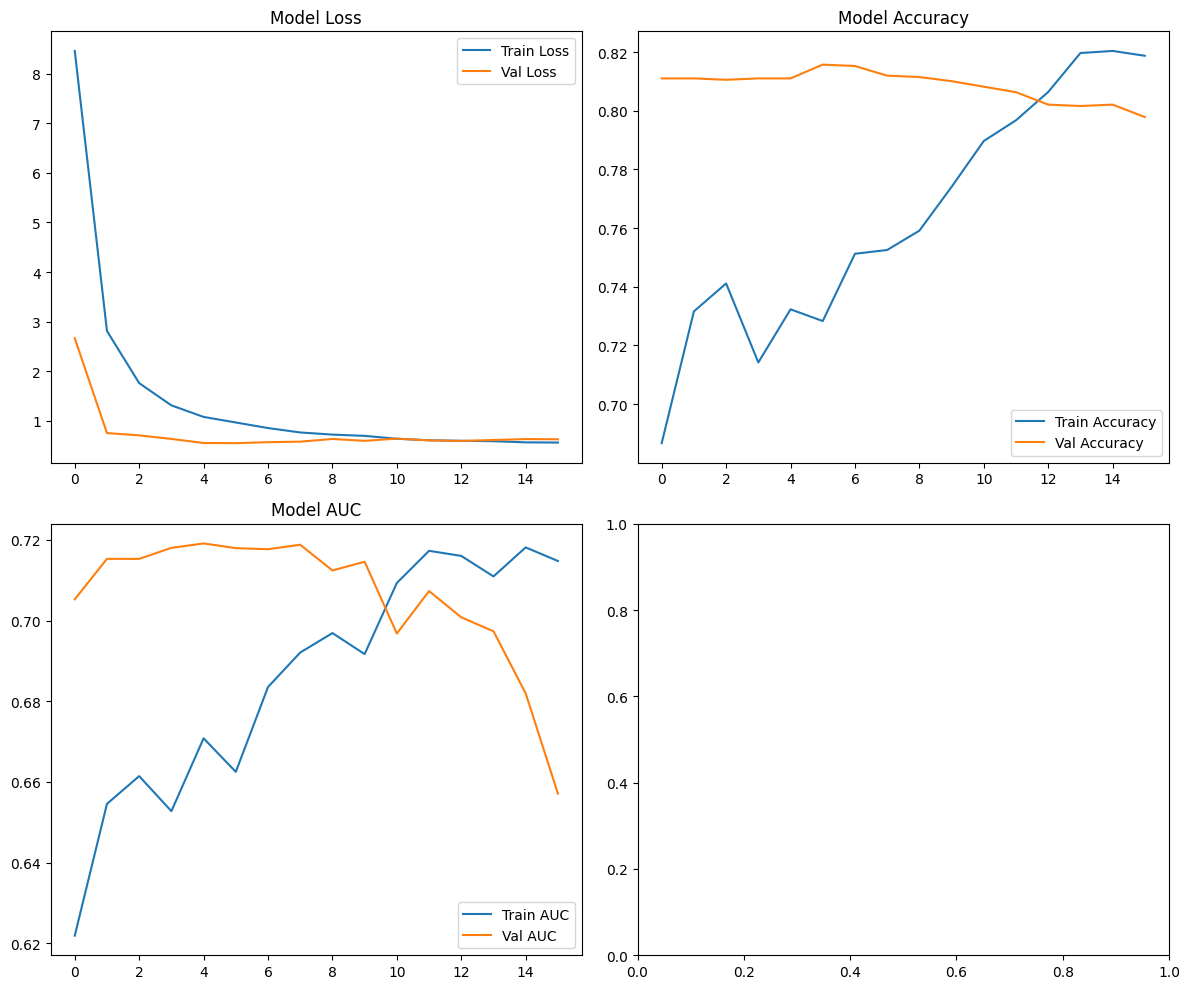

In [40]:
trainer.plot_training_history()

### Model Evalution and Optimization


In [18]:
from sklearn.metrics import classification_report, roc_auc_score, log_loss, roc_curve